In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from farmsize import data_prep
from shapely.geometry import Point


In [2]:
indicator_data = pd.read_csv("./data/RHoMIS_Indicators.csv", encoding="latin") 
countries= ["KE","TZ", "UG","BF","ML","GH","CI","NE"]
indicator_data = data_prep.subset_data(indicator_data, complete_gps=True, countries=countries)
indicator_data.head()

,ID_PROJ,ID_COUNTRY,YEAR,ITERATION,SURVEY_ID,ID_HH,RHoMIS_ID,GPS_LAT,GPS_LON,GPS_ALT,...,GHGEmissions,Gender_MaleControl,Gender_FemaleControl,Gender_MaleYouthControl,Gender_FemaleYouthControl,NFertInput,CropDiv,LivestockDiv,HHid.HHid,HHid.HHid.1
0,ADN,BF,2019.0,1.0,BF_ADN_2019,BF_2019_ADN_1_1,BF_2019_ADN_1_1,11.19,-0.95,254.0,...,702.949550,0.696542,0.303458,0.0,0.0,NaN,8,6,NaN,NaN
1,ADN,BF,2019.0,1.0,BF_ADN_2019,BF_2019_ADN_2_1,BF_2019_ADN_2_1,11.19,-0.95,346.0,...,94415.087935,0.539852,0.460148,0.0,0.0,100.0,13,7,NaN,NaN
2,ADN,BF,2019.0,1.0,BF_ADN_2019,BF_2019_ADN_3_1,BF_2019_ADN_3_1,11.19,-0.99,324.0,...,113.654565,0.695815,0.304185,0.0,0.0,50.0,9,2,NaN,NaN
3,ADN,BF,2019.0,1.0,BF_ADN_2019,BF_2019_ADN_4_1,BF_2019_ADN_4_1,11.19,-0.99,326.0,...,43062.200002,0.243574,0.756426,0.0,0.0,150.0,7,7,NaN,NaN
4,ADN,BF,2019.0,1.0,BF_ADN_2019,BF_2019_ADN_5_1,BF_2019_ADN_5_1,11.22,-1.02,308.0,...,13331.792068,0.606037,0.393963,0.0,0.0,250.0,8,5,NaN,NaN


In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [4]:
# Spatially joining the two datasets
indicator_data["geometry"] = [Point(xy) for xy in zip(indicator_data["GPS_LON"], indicator_data["GPS_LAT"])]
geo_indicator = gpd.GeoDataFrame(indicator_data)
geo_indicator = geo_indicator.sjoin(world, how="left", op="within")


<AxesSubplot:>

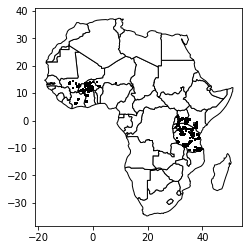

In [5]:
# Plot the points on a map
fig, ax =  plt.subplots()
ax.set_aspect('equal')
#Plot map layer
world.loc[world["continent"]=="Africa",].plot(ax=ax,color="white", edgecolor="black")
#Plot Points
geo_indicator.plot(ax=ax, marker=0, color='black', markersize=5)

ID_COUNTRY
BF    AxesSubplot(0.125,0.125;0.775x0.755)
CI    AxesSubplot(0.125,0.125;0.775x0.755)
GH    AxesSubplot(0.125,0.125;0.775x0.755)
KE    AxesSubplot(0.125,0.125;0.775x0.755)
ML    AxesSubplot(0.125,0.125;0.775x0.755)
NE    AxesSubplot(0.125,0.125;0.775x0.755)
TZ    AxesSubplot(0.125,0.125;0.775x0.755)
UG    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

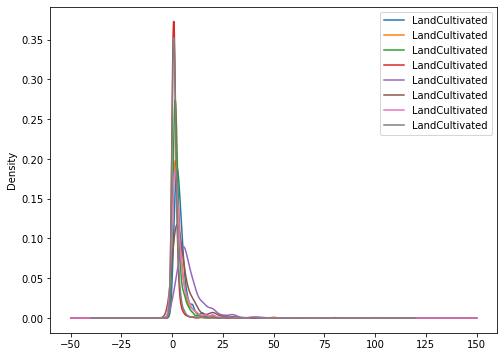

In [40]:
# Grouping by 
row_subsets = indicator_data["LandCultivated"].notna() & indicator_data["LandCultivated"].between(0.05,100)
column_subsets= ["ID_COUNTRY", "LandCultivated"]
grouping="ID_COUNTRY"

fig, ax = plt.subplots(figsize=(8,6))
indicator_data.loc[row_subsets,column_subsets].groupby("ID_COUNTRY").plot(kind="kde", ax=ax)